In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [5]:
import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import Model

In [6]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

# read the data

In [7]:
train_csv = pd.read_csv('../data/train/train.csv')

In [8]:
train_csv.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [9]:
#train_csv['id']

In [10]:
ids = train_csv.id.tolist()

In [11]:
images = np.array(list(map(lambda x: cv2.imread('../data/train/images/'+ x + '.png'), ids)))


In [12]:
rle_mask = train_csv.rle_mask.isna()

# Build binary classifier

## Split the data

In [13]:
img_size_ori = 101
img_size_target = 197

In [14]:
images.shape

(4000, 101, 101, 3)

In [15]:
#Reshape
images = np.array(list(map(lambda x: cv2.resize(x, (img_size_target, img_size_target)), images)))

In [16]:
images.shape

(4000, 197, 197, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, rle_mask, test_size=0.2, random_state=42)

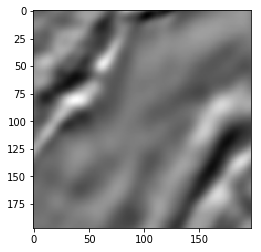

In [18]:
plt.imshow(X_train[1].astype(np.uint8))

In [19]:
X_train = X_train.astype("float")
X_test = X_test.astype("float")

# apply mean subtraction to the data
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train -= mean
# X_test -= mean

# X_train /= std
# X_test /= std

X_train /= 255.
X_test /= 255.

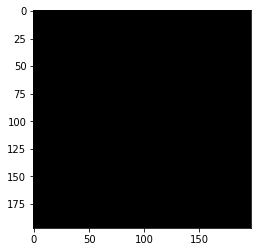

In [20]:
plt.imshow(X_train[1].astype(np.uint8))

In [21]:
# images = images.astype("float")
# images -= mean
# images /= std

In [22]:
# plt.imshow(images[3982].astype(np.uint8))

## Build the model

In [23]:
#vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size_target, img_size_target, 3))
vgg = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= (img_size_target, img_size_target, 3), pooling=None, )
#vgg = ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape= None, pooling=None, )


In [24]:
vgg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [25]:
##VGG top layer
#layers = dict([(layer.name, layer) for layer in vgg.layers])
##vgg_top = layers['block5_conv2'].output
#vgg_top = layers['block5_pool'].output

#Resnet top layer
resnet_top = vgg.layers[173].output

x = Flatten(name='flatten')(resnet_top)#(vgg_top) #(resnet_top)#
#x = Dense(2048, activation='relu', name='fc1')(x)
#x = Dense(1024, activation='relu', name='fc2')(x)
#x = Dense(512, activation='relu', name='fc3')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(input=vgg.input, output=x)

NameError: name 'vgg_top' is not defined

In [ ]:
my_model.summary()

In [ ]:
for layer in vgg.layers:#[:141]:
    layer.trainable = False

In [ ]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
my_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=45,
    horizontal_flip=True,
    vertical_flip=True)


datagen.fit(X_train)

In [ ]:
# fits the model on batches with real-time data augmentation:
# my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
#                     steps_per_epoch=len(X_train) / 32, epochs=5)

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras_classfier.model", save_best_only=True, verbose=2)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=2)

epochs = 200
batch_size = 32
steps_per_epoch=len(X_train) / 32

# history = my_model.fit(X_train, y_train, 
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     callbacks=[early_stopping, model_checkpoint, reduce_lr])

history = my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=[X_test, y_test],
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [ ]:
# labelNames = ['No','Yes']
# # evaluate the network
# print("[INFO] evaluating network...")
predictions = my_model.predict(X_test, batch_size=32)


In [ ]:
#print(classification_report(y_test.argmax(axis=1),
#    predictions.argmax(axis=1), target_names=labelNames))

In [ ]:
#predictions

In [ ]:
#predictions = my_model.predict_classes(X_test, batch_size=32)

In [ ]:
#y_test

In [ ]:
import os.path
from glob import glob

image_paths = glob(os.path.join('../data/test', 'images', '*.png'))

images_test = []
images_name = []

for image_path in image_paths:

    #img = imread(image_path, as_gray=False)
    img = np.array(cv2.imread(image_path))

    if img_size_ori != img_size_target:
        img = cv2.resize(img, (img_size_target, img_size_target))

    #Get label value
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]        
           
    images_test.append(img)
    images_name.append(image_name) 
    
    

images_test = np.array(images_test)
images_name = np.array(images_name)

In [ ]:
plt.imshow(images_test[3982].astype(np.uint8))

In [ ]:
images_test = images_test.astype("float")
# images_test -= mean
# images_test /= std
images_test /= 255.

In [ ]:
predict_img_test = my_model.predict(images_test, batch_size=32)

In [ ]:
predict_img_test

In [ ]:
df = pd.DataFrame({'id':images_name[:], 'predictions':predict_img_test[:,0]})

In [ ]:
df.to_csv('imagefromclassifier_v2.csv')